In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [3]:
#// opening raw data
df = pd.read_csv(
    "data/raw/Hand_open.csv",
    skiprows=8,
    header=None,
    engine="python",
    on_bad_lines="skip"
)


# Delsys pattern: EMG amplitude every 18 columns, starting at index 1
emg_cols = list(range(1, df.shape[1], 18))

emg = (
    df.iloc[:, emg_cols]
    .apply(pd.to_numeric, errors="coerce")
    .to_numpy(dtype=np.float64)
)

# Drop rows that are entirely NaN 
emg = emg[~np.isnan(emg).all(axis=1)]

print("EMG shape:", emg.shape)
print("dtype:", emg.dtype)


EMG shape: (57919, 6)
dtype: float64


In [4]:
# standard emg = 20-450 hz
# filtfilt is the zero-phase / no delay

def bandpass_emg(x, fs=1000, low=20, high=450, order=4):
    nyq = fs / 2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)


In [5]:
# applying the filter 

fs = 1000  # sampling frequency, how many samples / sec. 1 sample = 1 millisecond 
emg_filt = bandpass_emg(emg, fs=fs)

print("Filtered shape:", emg_filt.shape)


Filtered shape: (57919, 6)


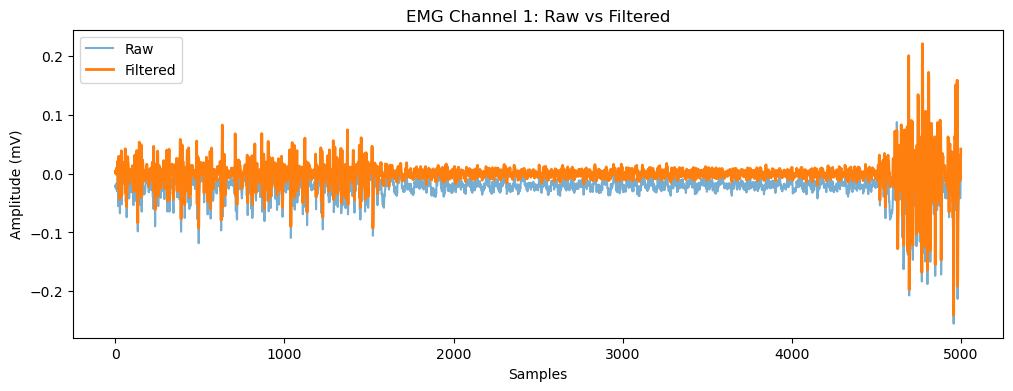

In [25]:
ch = 0
# extensor carpi radialis ch = 0
# pronator teres ch = 1
# flexor carpi ulnaris ch = 2
# extensor digitorum ch = 3
# flexor digitorum ch = 4
# flexor carpi radialis = 5 

plt.figure(figsize=(12,4))
plt.plot(emg[:5000, ch], label="Raw", alpha=0.6)
plt.plot(emg_filt[:5000, ch], label="Filtered", linewidth=2)
plt.legend()
plt.title(f"EMG Channel {ch+1}: Raw vs Filtered")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.show()

#Channel 4 and 6 sus, no cap
#ch 2 strong DC offset 
#ch 4 very large spikes 
#ch 6 no graph, empty? 

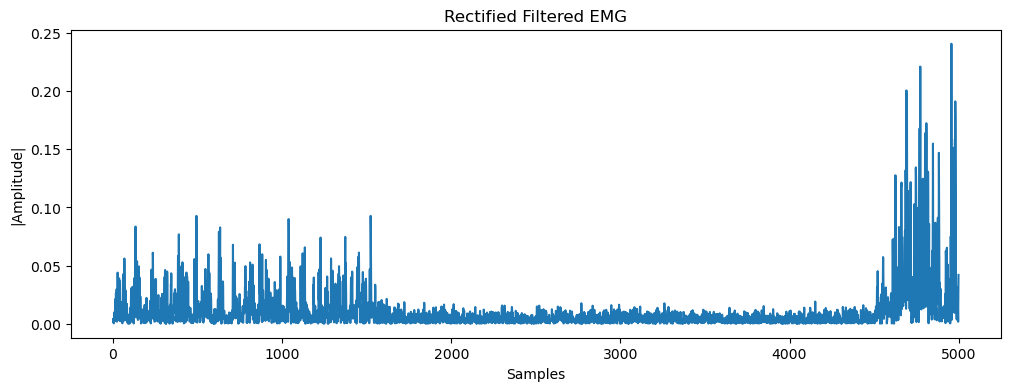

In [17]:
# rectified filtering EMG
# enveloped view shows muscle effort over time, peaks muscle atcivtations, valleys rest

plt.figure(figsize=(12,4))
plt.plot(np.abs(emg_filt[:5000, ch]))
plt.title("Rectified Filtered EMG")
plt.xlabel("Samples")
plt.ylabel("|Amplitude|")
plt.show()


In [24]:
for i in range(6):
    print(i, np.nanstd(emg_filt[:, i]))

# Scuffed. ch 1 - 3 are effectively dead. 
# missing welch power

0 0.03673183383283291
1 nan
2 nan
3 nan
4 0.008911817698153546
5 nan


C:\Users\gaaya\Anaconda3\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [26]:
valid_ch = ~np.isnan(np.nanstd(emg, axis=0))
valid_ch


array([ True,  True,  True,  True,  True, False])

In [28]:
valid_ch = ~np.isnan(np.nanstd(emg, axis=0))
emg = emg[:, valid_ch]
emg_filt = emg_filt[:, valid_ch]

print("Final EMG shape:", emg_filt.shape)


Final EMG shape: (57919, 5)
